# Aim 
> Here we are replicating our progress in the notebook 31-Node classification. Instead of dichotomizing upvotes, we are using it as a continuous variable and we are solving a regression task

In [1]:
pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 5.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910476 sha256=acdf7640d6f21927e3017cd28f2e2a04c24757219825c4bd463fcc33607542a7
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


## Importing libraries

In [2]:
import pandas as pd 
import numpy as np
import collections

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.utils.convert import to_networkx
from torch_geometric.nn import GCNConv, SGConv

import networkx as nx

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/vanderbilt/social/project')

Mounted at /content/drive


## Data munging

In [4]:
users = pd.read_csv("users.csv", header= None)
edges = pd.read_csv("edges.csv", header = None)
df = pd.read_csv("df.csv", index_col = 0)

In [5]:
users = users.reset_index()

In [6]:
users.columns = ["userid", 'username']

In [7]:
users

,userid,username
0,0,that_90s_guy
1,1,AutoModerator
2,2,scumbagdetector15
3,3,csch2
4,4,PlayerofVideoGames
...,...,...
608,608,Lanky_Information825
609,609,xebeka6808
610,610,HumanJenoM
611,611,mvandemar


In [8]:
df

,comment_karma,link_karma,avg_upvotes
that_90s_guy,31343.0,20684.0,1503.390000
AutoModerator,1000.0,1000.0,1.004695
scumbagdetector15,18369.0,1.0,170.600000
csch2,1981.0,2622.0,136.000000
PlayerofVideoGames,18476.0,473.0,57.000000
...,...,...,...
Lanky_Information825,326.0,3.0,5.000000
xebeka6808,4631.0,765.0,5.000000
HumanJenoM,8117.0,505.0,3.000000
mvandemar,4467.0,2391.0,2.000000


In [9]:
node_features = df[["comment_karma", "link_karma"]]
num_classes = 1

In [10]:
node_features

,comment_karma,link_karma
that_90s_guy,31343.0,20684.0
AutoModerator,1000.0,1000.0
scumbagdetector15,18369.0,1.0
csch2,1981.0,2622.0
PlayerofVideoGames,18476.0,473.0
...,...,...
Lanky_Information825,326.0,3.0
xebeka6808,4631.0,765.0
HumanJenoM,8117.0,505.0
mvandemar,4467.0,2391.0


In [11]:
# Convert to numpy
x = torch.tensor(node_features.values)
x.shape # [num_nodes x num_features]

torch.Size([613, 2])

In [12]:
df

,comment_karma,link_karma,avg_upvotes
that_90s_guy,31343.0,20684.0,1503.390000
AutoModerator,1000.0,1000.0,1.004695
scumbagdetector15,18369.0,1.0,170.600000
csch2,1981.0,2622.0,136.000000
PlayerofVideoGames,18476.0,473.0,57.000000
...,...,...,...
Lanky_Information825,326.0,3.0,5.000000
xebeka6808,4631.0,765.0,5.000000
HumanJenoM,8117.0,505.0,3.000000
mvandemar,4467.0,2391.0,2.000000


In [13]:
y = torch.tensor(df.avg_upvotes, dtype=torch.float)
y.shape

torch.Size([613])

In [14]:
edges[['source', 'dest']] = edges[0].str.split("###", expand = True)

In [15]:
edges

,0,source,dest
0,AutoModerator###that_90s_guy,AutoModerator,that_90s_guy
1,scumbagdetector15###that_90s_guy,scumbagdetector15,that_90s_guy
2,csch2###scumbagdetector15,csch2,scumbagdetector15
3,scumbagdetector15###csch2,scumbagdetector15,csch2
4,PlayerofVideoGames###scumbagdetector15,PlayerofVideoGames,scumbagdetector15
...,...,...,...
1669,flossraptor###Alternative_Ad_9702,flossraptor,Alternative_Ad_9702
1670,Timofey_###Alternative_Ad_9702,Timofey_,Alternative_Ad_9702
1671,Alternative_Ad_9702###Alternative_Ad_9702,Alternative_Ad_9702,Alternative_Ad_9702
1672,xebeka6808###Alternative_Ad_9702,xebeka6808,Alternative_Ad_9702


In [16]:
edges = edges[['source', 'dest']]

In [17]:
edges['source']

0             AutoModerator
1         scumbagdetector15
2                     csch2
3         scumbagdetector15
4        PlayerofVideoGames
               ...         
1669            flossraptor
1670               Timofey_
1671    Alternative_Ad_9702
1672             xebeka6808
1673             xebeka6808
Name: source, Length: 1674, dtype: object

In [18]:
# Perform merge to obtain the edges from users and movies:
edges_source_id = pd.merge(edges['source'], users,
                            left_on='source', right_on='username', how='left')

In [19]:
users

,userid,username
0,0,that_90s_guy
1,1,AutoModerator
2,2,scumbagdetector15
3,3,csch2
4,4,PlayerofVideoGames
...,...,...
608,608,Lanky_Information825
609,609,xebeka6808
610,610,HumanJenoM
611,611,mvandemar


In [20]:
edges_source_id = torch.from_numpy(edges_source_id['userid'].values)

In [21]:
edges_source_id

tensor([  1,   2,   3,  ..., 606, 609, 609])

In [22]:
edges_dest_id = pd.merge(edges['dest'], users,
                            left_on='dest', right_on='username', how='left')
edges_dest_id = torch.from_numpy(edges_dest_id['userid'].values)


In [23]:
edges_dest_id

tensor([  0,   0,   2,  ..., 606, 606, 606])

In [24]:
# # With this, we are ready to construct our `edge_index` in COO format
# # following PyG semantics:
edge_source_dest = torch.stack([edges_source_id, edges_dest_id], dim=0)


In [25]:
x = torch.tensor(x.float())
y = torch.tensor(y).ravel()

<ipython-input-25-4bfdc6061317>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x.float())
<ipython-input-25-4bfdc6061317>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).ravel()


In [26]:
y.shape

torch.Size([613])

## Graph creation

In [27]:
data = Data(x= x , edge_index=edge_source_dest, y=y, num_classes = num_classes)

In [28]:
data

Data(x=[613, 2], edge_index=[2, 1674], y=[613], num_classes=1)

In [29]:
from torch_geometric.transforms import RandomNodeSplit as masking

Probably this is not the best way to split. Probably splitting using random links would be better

In [30]:
msk=masking(split="train_rest", num_splits = 1, num_val = 0.2, num_test= 0.2)
data=msk(data)
print(data)
print()
print("training samples",torch.sum(data.train_mask).item())
print("validation samples",torch.sum(data.val_mask ).item())
print("test samples",torch.sum(data.test_mask ).item())

# Hands-on Graph Neural Networks for Social Network Using PyTorch | by Awadelrahman M. A. Ahmed | Medium
# https://awadrahman.medium.com/hands-on-graph-neural-networks-for-social-network-using-pytorch-30231c130b38


Data(x=[613, 2], edge_index=[2, 1674], y=[613], num_classes=1, train_mask=[613], val_mask=[613], test_mask=[613])

training samples 367
validation samples 123
test samples 123


In [31]:
num_of_feat=data.num_node_features

In [32]:
num_of_feat

2

## setting seeds

In [33]:
import random

import numpy as np
from torch_geometric.seed import seed_everything
seed_everything(4)

## GCN regression

In [34]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 16, dropout=dropout)
        self.conv2 = GCNConv(16, data.num_classes)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=self.dropout)
        x = self.conv2(x, edge_index)

        return x

In [35]:
model = GCN(dropout = 0.2)#
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.001)
criterion = torch.nn.MSELoss()

model.train()
loss_values = []
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])

    loss_values.append(loss.item())
    loss.backward()
    optimizer.step()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([367])) that is different to the input size (torch.Size([367, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


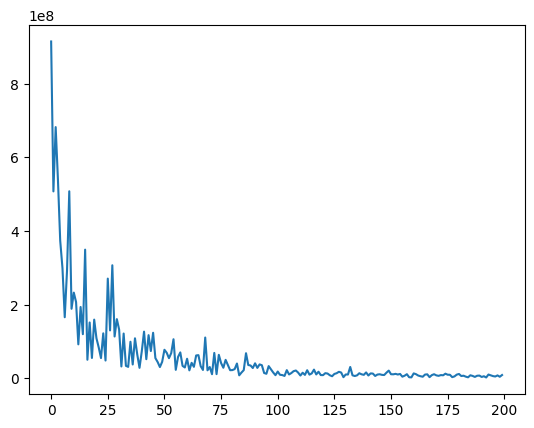

In [36]:
plt.plot(loss_values);

In [37]:
# Evaluate model on valid set
model.eval()
with torch.no_grad():
  out = model(data)
  mse_loss = criterion(out[data.val_mask].squeeze(), data.y[data.val_mask].squeeze())
  print(f'Val set MSE: {mse_loss.item():.4f}')
  print(f'val RMSE: {mse_loss.sqrt():.4f}')


Val set MSE: 3484584.5000
val RMSE: 1866.7042


### Hyperparameter tuning  

- Number of layers:  1, 2, and also 5
- L2 regularization on the neural network weight matrices/parameters
(i.e., weight decay parameter: 0, 1e-4, and 1e-2)
- Learning rate given as input to torch.optim.Adam(): 1e-5 and 1e-2

I will calculate the mean and standard deviation of 3 runs 

#### 2 layers implemenattion

In [38]:
# Define the ranges for each hyperparameter
weight_decays = [0, 1e-4, 1e-2] 
learning_rates = [1e-5, 1e-2]
dropout_rates = [0, 0.2, 0.4, 0.6]

# Define the number of times to repeat for each set of hyperparameters
num_repeats = 3

# Initialize a dictionary to store the results
results = {}

# Loop over all possible combinations of hyperparameters
for weight_decay in weight_decays:
      for learning_rate in learning_rates:
          for dropout_rate in dropout_rates:
          
            # Initialize the model and optimizer with the current hyperparameters
            model = GCN(dropout = dropout_rate)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

            # Train the model and get the RMSE for each repeat
            rmse_list = []
            for repeat in range(num_repeats):
                model.train()
                for epoch in range(200):
                    optimizer.zero_grad()
                    out = model(data)
                    loss = criterion(out[data.train_mask], data.y[data.train_mask])
                    loss.backward()
                    optimizer.step()
                with torch.no_grad():
                  model.eval()
                  rmse_loss = criterion(out[data.val_mask].squeeze(), data.y[data.val_mask].squeeze()).sqrt()
                  rmse_list.append(rmse_loss)

            # Calculate the mean and standard deviation of accuracy for the current hyperparameters
            rmse_mean = round(np.mean(rmse_list),4)
            rmse_std = round(np.std(rmse_list),4)
            
            # Store the results in the dictionary
            results[(weight_decay,learning_rate, dropout_rate)] = (rmse_mean, rmse_std)


In [39]:
results

{(0, 1e-05, 0): (11650.515, 601.2841),
 (0, 1e-05, 0.2): (20162.17, 5809.823),
 (0, 1e-05, 0.4): (18560.436, 2113.7913),
 (0, 1e-05, 0.6): (26347.463, 7655.7734),
 (0, 0.01, 0): (882.9565, 11.8175),
 (0, 0.01, 0.2): (1148.3605, 318.698),
 (0, 0.01, 0.4): (916.9659, 54.6309),
 (0, 0.01, 0.6): (1925.027, 1059.5215),
 (0.0001, 1e-05, 0): (9823.976, 681.1061),
 (0.0001, 1e-05, 0.2): (30224.623, 3833.534),
 (0.0001, 1e-05, 0.4): (12915.86, 3795.743),
 (0.0001, 1e-05, 0.6): (30653.588, 13373.654),
 (0.0001, 0.01, 0): (955.1972, 103.0938),
 (0.0001, 0.01, 0.2): (906.0556, 57.0247),
 (0.0001, 0.01, 0.4): (2704.9812, 1492.7216),
 (0.0001, 0.01, 0.6): (2781.088, 2186.8464),
 (0.01, 1e-05, 0): (36730.09, 525.6285),
 (0.01, 1e-05, 0.2): (8654.401, 3243.6235),
 (0.01, 1e-05, 0.4): (23473.455, 691.0958),
 (0.01, 1e-05, 0.6): (47910.348, 14464.592),
 (0.01, 0.01, 0): (844.2192, 11.4919),
 (0.01, 0.01, 0.2): (950.9655, 95.1252),
 (0.01, 0.01, 0.4): (1392.8174, 349.7928),
 (0.01, 0.01, 0.6): (1083.4581

#### One layer implementation 

In [40]:
class GCN_1(torch.nn.Module):
    def __init__(self, dropout = 0):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, data.num_classes)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        # x = F.relu(x)
        #x = F.dropout(x, training=self.training, p=self.dropout)
        # x = self.conv2(x, edge_index)

        return x

In [41]:
# Define the ranges for each hyperparameter
weight_decays = [0, 1e-4, 1e-2] 
learning_rates = [1e-5, 1e-2]
dropout_rates = [0, 0.2, 0.4, 0.6]

# Define the number of times to repeat for each set of hyperparameters
num_repeats = 3

# Initialize a dictionary to store the results
results_1L = {}

# Loop over all possible combinations of hyperparameters
for weight_decay in weight_decays:
      for learning_rate in learning_rates:
          for dropout_rate in dropout_rates:
          
            # Initialize the model and optimizer with the current hyperparameters
            model = GCN_1(dropout = dropout_rate)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

            # Train the model and get the RMSE for each repeat
            rmse_list = []
            for repeat in range(num_repeats):
                model.train()
                for epoch in range(200):
                    optimizer.zero_grad()
                    out = model(data)
                    loss = criterion(out[data.train_mask], data.y[data.train_mask])
                    loss.backward()
                    optimizer.step()
                with torch.no_grad():
                  model.eval()
                  rmse_loss = criterion(out[data.val_mask].squeeze(), data.y[data.val_mask].squeeze()).sqrt()
                  rmse_list.append(rmse_loss)

            # Calculate the mean and standard deviation of accuracy for the current hyperparameters
            rmse_mean = round(np.mean(rmse_list),4)
            rmse_std = round(np.std(rmse_list),4)
            
            # Store the results in the dictionary
            results_1L[(weight_decay,learning_rate, dropout_rate)] = (rmse_mean, rmse_std)


In [42]:
results_1L

{(0, 1e-05, 0): (94490.15, 157.9985),
 (0, 1e-05, 0.2): (66503.57, 73.9321),
 (0, 1e-05, 0.4): (51944.363, 148.9086),
 (0, 1e-05, 0.6): (67766.85, 159.0733),
 (0, 0.01, 0): (6546.144, 4846.365),
 (0, 0.01, 0.2): (845.0322, 7.4106),
 (0, 0.01, 0.4): (850.5784, 0.6398),
 (0, 0.01, 0.6): (3270.1357, 2653.068),
 (0.0001, 1e-05, 0): (109131.63, 159.7686),
 (0.0001, 1e-05, 0.2): (64431.902, 127.0641),
 (0.0001, 1e-05, 0.4): (101163.76, 159.4752),
 (0.0001, 1e-05, 0.6): (78593.87, 42.3687),
 (0.0001, 0.01, 0): (4196.2876, 4600.9517),
 (0.0001, 0.01, 0.2): (851.3967, 1.8272),
 (0.0001, 0.01, 0.4): (850.0828, 0.0361),
 (0.0001, 0.01, 0.6): (1715.5316, 1223.5195),
 (0.01, 1e-05, 0): (106510.12, 159.185),
 (0.01, 1e-05, 0.2): (51282.355, 99.2809),
 (0.01, 1e-05, 0.4): (56857.37, 82.1779),
 (0.01, 1e-05, 0.6): (56259.848, 108.0136),
 (0.01, 0.01, 0): (4371.0454, 4435.8413),
 (0.01, 0.01, 0.2): (1344.2264, 696.1675),
 (0.01, 0.01, 0.4): (850.2004, 0.1216),
 (0.01, 0.01, 0.6): (9235.666, 7416.242)}

#### Five layers implementation 

In [43]:
class GCN_5(torch.nn.Module):
    def __init__(self, dropout = 0):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 16, dropout=dropout)
        self.conv2 = GCNConv(16, 16, dropout=dropout)
        self.conv3 = GCNConv(16, 16, dropout=dropout)
        self.conv4 = GCNConv(16, 16, dropout=dropout)
        self.conv5 = GCNConv(16, data.num_classes)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=self.dropout)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=self.dropout)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=self.dropout)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=self.dropout)
        x = self.conv5(x, edge_index)


        return x

In [44]:
# Define the ranges for each hyperparameter
weight_decays = [0, 1e-4, 1e-2] 
learning_rates = [1e-5, 1e-2]
dropout_rates = [0, 0.2, 0.4, 0.6]

# Define the number of times to repeat for each set of hyperparameters
num_repeats = 3

# Initialize a dictionary to store the results
results_5L = {}

# Loop over all possible combinations of hyperparameters
for weight_decay in weight_decays:
      for learning_rate in learning_rates:
          for dropout_rate in dropout_rates:
          
            # Initialize the model and optimizer with the current hyperparameters
            model = GCN_5(dropout = dropout_rate)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

            # Train the model and get the RMSE for each repeat
            rmse_list = []
            for repeat in range(num_repeats):
                model.train()
                for epoch in range(200):
                    optimizer.zero_grad()
                    out = model(data)
                    loss = criterion(out[data.train_mask], data.y[data.train_mask])
                    loss.backward()
                    optimizer.step()
                with torch.no_grad():
                  model.eval()
                  rmse_loss = criterion(out[data.val_mask].squeeze(), data.y[data.val_mask].squeeze()).sqrt()
                  rmse_list.append(rmse_loss)

            # Calculate the mean and standard deviation of accuracy for the current hyperparameters
            rmse_mean = round(np.mean(rmse_list),4)
            rmse_std = round(np.std(rmse_list),4)
            
            # Store the results in the dictionary
            results_5L[(weight_decay,learning_rate, dropout_rate)] = (rmse_mean, rmse_std)


In [45]:
results_5L

{(0, 1e-05, 0): (17275.105, 1271.1829),
 (0, 1e-05, 0.2): (9890.324, 5175.987),
 (0, 1e-05, 0.4): (25177.375, 4752.408),
 (0, 1e-05, 0.6): (39382.27, 17838.385),
 (0, 0.01, 0): (886.5779, 55.7159),
 (0, 0.01, 0.2): (881.4771, 25.7995),
 (0, 0.01, 0.4): (895.1348, 56.0937),
 (0, 0.01, 0.6): (1123.4532, 357.8025),
 (0.0001, 1e-05, 0): (2182.8018, 575.4663),
 (0.0001, 1e-05, 0.2): (23514.352, 2354.3564),
 (0.0001, 1e-05, 0.4): (31160.906, 7188.9497),
 (0.0001, 1e-05, 0.6): (104951.44, 65356.59),
 (0.0001, 0.01, 0): (864.7407, 25.1336),
 (0.0001, 0.01, 0.2): (854.4312, 0.6263),
 (0.0001, 0.01, 0.4): (1137.4663, 383.3751),
 (0.0001, 0.01, 0.6): (1701.5796, 1182.1943),
 (0.01, 1e-05, 0): (4371.789, 403.0548),
 (0.01, 1e-05, 0.2): (14210.834, 6304.591),
 (0.01, 1e-05, 0.4): (24082.232, 7379.8394),
 (0.01, 1e-05, 0.6): (30278.4, 9708.526),
 (0.01, 0.01, 0): (849.6714, 1.4276),
 (0.01, 0.01, 0.2): (863.1802, 14.1088),
 (0.01, 0.01, 0.4): (925.7659, 39.4468),
 (0.01, 0.01, 0.6): (901.0834, 24.71

#### Adding all results to a table

In [46]:
import pandas as pd
combined_dict = {}
combined_dict.update({1: results_1L})
combined_dict.update({2: results})
combined_dict.update({5: results_5L})

# Convert the dictionary into a pandas DataFrame
rows = []
for dict_type, inner_dict in combined_dict.items():
    for key, value in inner_dict.items():
        rows.append((dict_type, key, round(value[0],4), round(value[1],4)))

df = pd.DataFrame(rows, columns=['Layers', 'WD_LR_dropout', 'RMSE_mean', 'RMSE_std_dev'])

In [47]:
sorted_df = df.sort_values(by=['RMSE_mean'], ascending=True)
sorted_df

,Layers,WD_LR_dropout,RMSE_mean,RMSE_std_dev
44,2,"(0.01, 0.01, 0)",844.219177,11.491900
5,1,"(0, 0.01, 0.2)",845.032227,7.410600
68,5,"(0.01, 0.01, 0)",849.671387,1.427600
14,1,"(0.0001, 0.01, 0.4)",850.082825,0.036100
22,1,"(0.01, 0.01, 0.4)",850.200378,0.121600
...,...,...,...,...
0,1,"(0, 1e-05, 0)",94490.148438,157.998505
10,1,"(0.0001, 1e-05, 0.4)",101163.757812,159.475204
59,5,"(0.0001, 1e-05, 0.6)",104951.437500,65356.589844
16,1,"(0.01, 1e-05, 0)",106510.117188,159.184998


I have a rounding problem here that I am not able to solve

Best performance is for 2 layers, a weight decay of 0.01, a learning rate of 0.01 and a dropout rate of 0. We will use this on the test set 

## Evaluate on the test set

In [48]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 16, dropout=dropout)
        self.conv2 = GCNConv(16, data.num_classes)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=self.dropout)
        x = self.conv2(x, edge_index)

        return x

In [51]:
model = GCN(dropout = 0)#
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.01)
criterion = torch.nn.MSELoss()

model.train()
loss_values = []
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask].squeeze(), data.y[data.train_mask].squeeze())

    loss_values.append(loss.item())
    loss.backward()
    optimizer.step()

In [52]:
# Evaluate model on valid set
model.eval()
with torch.no_grad():
  out = model(data)
  mse_loss = criterion(out[data.test_mask].squeeze(), data.y[data.test_mask].squeeze())
  print(f'Val set MSE: {mse_loss.item():.4f}')
  print(f'val RMSE: {mse_loss.sqrt():.4f}')


Val set MSE: 109034.5625
val RMSE: 330.2038


## References

Link Regression on Movielens.ipynb - Colaboratory
https://colab.research.google.com/drive/1N3LvAO0AXV4kBPbTMX866OwJM9YS6Ji2?usp=sharing#scrollTo=_5_rbeCjJnsz  (useful for the loss function and metric)